In [36]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask

In [64]:
is_valid = False

path = '../input/'

def timeFeatures(df):
#     df['datetime'] = pd.to_datetime(df['click_time'])
    df['datetime'] = dd.to_datetime(df['click_time'])
    df['dow'] = df['datetime'].dt.dayofweek
    df['doy'] = df['datetime'].dt.dayofyear
#     df.drop(['click_time','datetime'],axis=1,inplace=True)
    df = df.drop(['click_time','datetime'],axis=1)
    return df

start_time = time.time()

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

# Read the last lines because they are more impacting in training than the starting lines
# train = pd.read_csv(path+"train.csv", skiprows=range(1,93903891), nrows=91000000, usecols=train_columns, dtype=dtypes)
# test = pd.read_csv(path+"test_supplement.csv", usecols=test_columns, dtype=dtypes)
train = dd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes)
test = dd.read_csv(path+"test_supplement.csv", usecols=test_columns, dtype=dtypes)

print('[{}] Finished to load data'.format(time.time() - start_time))

# Drop the IP and the columns from target
y = train['is_attributed']
# train.drop(['is_attributed'], axis=1, inplace=True)
train = train.drop(['is_attributed'], axis=1)

# Drop IP and ID from test rows
sub = pd.DataFrame()
#sub['click_id'] = test['click_id'].astype('int')
# test.drop(['click_id'], axis=1, inplace=True)
test = test.drop(['click_id'], axis=1)
gc.collect()

[0.13993525505065918] Finished to load data


1625

In [65]:
nrow_train = len(train)

In [22]:
# nrow_train

184903890

In [23]:
# len(test)

57537505

In [66]:
# nrow_train = train.shape[0]
# merge = pd.concat([train, test])
merge = dd.concat([train, test])
# merge.info()

In [67]:
del train, test
gc.collect()

1081

In [41]:
# merge.head()

In [42]:
# merge.info()

In [68]:
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()

In [44]:
# ip_count.head()

In [69]:
ip_count.columns = ['ip', 'clicks_by_ip']

In [70]:
# merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge = dd.merge(merge, ip_count, on='ip', how='left')

In [71]:
# merge.head()

In [72]:
merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
# merge.drop('ip', axis=1, inplace=True)
merge = merge.drop('ip', axis=1)

In [79]:
merge['index_num'] = merge.index
del merge['index']
# merge.head()
# train = merge.iloc[1:3,:]
# merge.where(cond[, other])
# merge.app
# hoge = merge[merge.index < 23]
# len(hoge)
# train = merge[:nrow_train]
# test = merge[nrow_train:]

# del test, merge
# gc.collect()

In [83]:
train = merge[merge.index_num < 5000]

In [84]:
len(train)

800000

In [20]:
# def timeFeatures(df):
# #     df['datetime'] = pd.to_datetime(df['click_time'])
#     df['datetime'] = dd.to_datetime(df['click_time'])
#     df['dow'] = df['datetime'].dt.dayofweek
#     df['doy'] = df['datetime'].dt.dayofyear
# #     df.drop(['click_time','datetime'],axis=1,inplace=True)
#     df = df.drop(['click_time','datetime'],axis=1)
#     return df

In [15]:
# print('[{}] Start to generate time features'.format(time.time() - start_time))

train = timeFeatures(train)
gc.collect()
# train.head()
# print('[{}] Start XGBoost Training'.format(time.time() - start_time))

,app,device,os,channel,clicks_by_ip,dow,doy
0,3,1,13,379,32794,0,310
1,3,1,19,379,30826,0,310
2,3,1,13,379,13162,0,310
3,14,1,13,478,23892,0,310
4,3,1,13,379,1171,0,310


In [16]:
len(train)

242441395

In [17]:
len(y)

184903890

In [22]:
# Set the params(this params from Pranav kernel) for xgboost model
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

is_valid = True

if (is_valid == True):    
    x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
    dtrain = xgb.DMatrix(x1, y1)
    dvalid = xgb.DMatrix(x2, y2)
    del x1, x2, y1, y2
    gc.collect()
    watchlist = [(dtrain, 'train'),(dvalid, 'valid')]
    model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds= 25, verbose_eval=5)
    del dvalid
else:
    dtrain = xgb.DMatrix(train, y)
    del train, y
    gc.collect()
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)
    
del dtrain
gc.collect()

ValueError: Found input variables with inconsistent numbers of samples: [4300042, 100000]

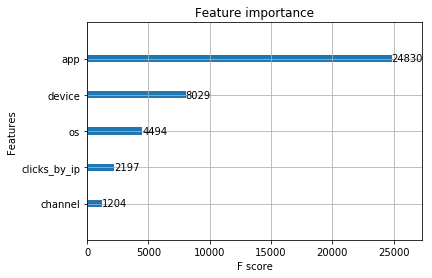

In [35]:
# print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

plot_importance(model)

In [13]:
# plt.gcf().savefig('feature_importnca_xgb.png')

test = pd.read_csv(path+"test.csv",usecols=test_columns, dtype=dtypes)
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
del ip_count
gc.collect()

21

In [14]:
sub['click_id'] = test['click_id'].astype('int')

test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)
dtest = xgb.DMatrix(test)
del test
gc.collect()

# Save the predictions
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv', float_format='%.8f', index=False)

In [ ]:
hoge = pd.read_csv(path+"train_sample.csv", usecols=train_columns, dtype=dtypes)